<font  style="font-size: 4rem; color: darkviolet"> Neural Networks in TensorFlow </font>

AA - 2022/23 - TP6

In this assignment, you will learn about TensorFlow, which is a helpful framework that can make it easier to create neural networks. After completing this assignment, you will know how to train a neural network using TensorFlow, change the values of variables using tf.Variable, and understand the difference between a variable and a constant. TensorFlow, along with other tools like Torch and PaddlePaddle, can speed up your machine learning development.

Resources:

Introduction to Gradients and Automatic Differentiation: 
https://www.tensorflow.org/guide/autodiff 

GradientTape documentation:
https://www.tensorflow.org/api_docs/python/tf/GradientTape


## Table of Contents
- [1 - Dataset](#1)
- [2 - Basic Optimization with GradientTape](#2)
    - [2.1 - Linear Function](#2.1)
        - [Exercise 1 - linear_function](#ex-1)
    - [2.2 - Computing the Sigmoid](#2.2)
        - [Exercise 2 - sigmoid](#ex-2)
    - [2.3 - Using One Hot Encodings](#2.3)
        - [Exercise 3 - one_hot_matrix](#ex-3)
    - [2.4 - Initialize the Parameters](#2.4)
        - [Exercise 4 - initialize_parameters](#ex-4)
- [3 - Building Your First Neural Network in TensorFlow](#3)
    - [3.1 - Implement Forward Propagation](#3.1)
        - [Exercise 5 - forward_propagation](#ex-5)
    - [3.2 Compute the Total Loss](#3.2)
        - [Exercise 6 - compute_total_loss](#ex-6)
    - [3.3 - Train the Model](#3.3)
        - [Exercise 7 - model](#ex-7)

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

2023-04-04 12:21:02.490384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 12:21:02.648100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 12:21:02.648126: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-04 12:21:03.502809: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

You will be using v2.x, for maximum speed and efficiency.

In [2]:
tf.__version__

'2.11.0'

<a name='1'></a>
## <font color='darkviolet'> 1 - Dataset

The `tf.Tensor` object is a fundamental data structure in TensorFlow used for manipulating and storing numerical data. Tensors are similar to Numpy arrays - they are multidimensional arrays with a specific data type and also contain information about the computational graph.
    
You will learn how to utilize a TensorFlow dataset created from an HDF5 file. This is a powerful alternative to using Numpy arrays for storing large datasets, as it enables you to work with streaming data, otherwise known as a TensorFlow data generator.

We will be using the Hand sign dataset, which consists of images with a shape of 64x64x3. It contains six different classes representing the digits from 0 to 5.

In [3]:
train_dataset = h5py.File('data/train_signs.h5', "r")
test_dataset = h5py.File('data/test_signs.h5', "r")

In [4]:
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

2023-04-04 12:21:04.989246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-04 12:21:04.989271: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-04 12:21:04.989292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fgalassi): /proc/driver/nvidia/version does not exist
2023-04-04 12:21:04.989566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
type(x_train)

tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset

TensorFlow datasets are implemented as generators, which means that their contents cannot be accessed directly. Instead, you must iterate over them in a for loop or explicitly create a Python iterator using `iter` and consume its elements using `next`. In addition, you can inspect the `shape` and `dtype` of each element in the dataset using the `element_spec` attribute. This provides a convenient way to understand the structure and data type of the dataset before iterating through its contents.

In [6]:
print(x_train.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [7]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [8]:
unique_labels = set()
for element in y_train:
    unique_labels.add(element.numpy())
print(unique_labels)

{0, 1, 2, 3, 4, 5}


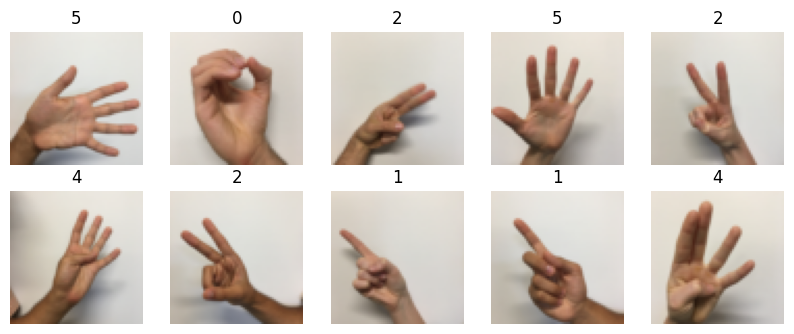

In [9]:
images_iter = iter(x_train)
labels_iter = iter(y_train)
plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

One of the key differences between Numpy arrays and TensorFlow datasets is the way in which you can apply transformations to the data. In TensorFlow datasets, you can use the `map()` method to apply a function to each element of the dataset.

In [10]:
def normalize(image):
    """
    Transform an image into a tensor of shape (64 * 64 * 3, )
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    # Convert the data type of the input image to float32 and normalize its components
    image = tf.cast(image, tf.float32) / 255.0
    
    # Reshape the image tensor into a 1D vector
    image = tf.reshape(image, [-1,])
    
    return image

In [11]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [12]:
new_train.element_spec

TensorSpec(shape=(12288,), dtype=tf.float32, name=None)

In [13]:
print(next(iter(new_train)))

tf.Tensor([0.8901961  0.8627451  0.8392157  ... 0.8156863  0.81960785 0.81960785], shape=(12288,), dtype=float32)


#### <font color='blue'>  Q1.1 What is a Tensor in TensorFlow, and how can you create a tf.data.Dataset from a Tensor? 
#### <font color='blue'>  Q1.2 Describe your dataset.

<a name='2'></a>
## <font color='darkviolet'> 2 - Basic Optimization with GradientTape

In TensorFlow, you just need to create a computational graph for forward propagation. TensorFlow will calculate derivatives with `GradientTape`, moving backwards through the graph. You must choose the cost function and optimizer.

<a name='2.1'></a>
## <font color='darkviolet'> 2.1 - Linear Function

In this programming exercise you will compute the following equation: $Z = WX + b$, where $W$ and $X$ are random matrices and $b$ is a random vector. 

<a name='ex-1'></a>
### <font color='blue'> Exercise 1 - linear_function

Compute $WX + b$ where $W, X$, and $b$ are drawn from a random normal distribution. 

$W$ is of shape (4, 3), $X$ is (3,1) and $b$ is (4,1). As an example, this is how to define a constant $X$ with the shape (3,1):
```python
X = tf.constant(np.random.randn(3,1), name = "X")

```
    
Note that the difference between `tf.constant` and `tf.Variable` is that you can modify the state of a `tf.Variable` but cannot change the state of a `tf.constant`.
    
For this exercise, you may find the following functions useful:
-  `np.random.randn(...)` to initialize random values for the matrices and vector.
-  `tf.matmul(..., ...)` to perform matrix multiplication
-  `tf.add(..., ...)` to perform addition

In [ ]:
def linear_function():
    """
    Implements a linear function: 
        Initializes X to be a random tensor of shape (3,1)
        Initializes W to be a random tensor of shape (4,3)
        Initializes b to be a random tensor of shape (4,1)
    Returns: 
        result -- Z = WX + b 
    """

    # Set the random seed for reproducibility
    np.random.seed(1)

    #TODO Initialize X, W, and b

    #TODO Compute Z = WX + b

    return Z

In [ ]:
result = linear_function()
print(result)

assert type(result) == EagerTensor, "Use the TensorFlow API"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92mAll test passed")

<a name='2.2'></a>
## <font color='darkviolet'> 2.2 -  Computing the Sigmoid

<a name='ex-2'></a>
### <font color='blue'> Exercise 2 -  sigmoid

TensorFlow provides several widely-used neural network functions, such as `tf.sigmoid` and `tf.softmax`.

For this exercise, you need to compute the sigmoid of `z`. The sigmoid expects its input to be in float format. By casting `z` to `float32`, we ensure that it is compatible with the sigmoid function.

You cast your tensor to the `float32` data type using `tf.cast`, then compute the sigmoid function using `tf.keras.activations.sigmoid`.

In [ ]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (tf.float32) the sigmoid of z
    """
    
    #TODO Cast input to float32 and compute sigmoid

    return a

In [ ]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))

def sigmoid_test(target):
    result = target(0)
    assert(type(result) == EagerTensor)
    assert (result.dtype == tf.float32)
    assert sigmoid(0) == 0.5, "Error"
    assert sigmoid(-1) == 0.26894143, "Error"

    print("\033[92mAll test passed")

sigmoid_test(sigmoid)

<a name='2.3'></a>
## <font color='darkviolet'> 2.3 - Using One Hot Encodings

In deep learning, you often have a $y$ vector with numbers ranging from $0$ to $C-1$, where $C$ is the number of classes. 
If $C$ is for example 4, then you might have the following $y$ vector which you will need to convert like this:

<img src="data/one_hot.png" style="width:600px;height:150px;">

This is called "one hot" encoding, because in the converted representation, exactly one element of each column is "hot" (meaning set to 1). To do this conversion in Numpy, you might have to write a few lines of code. In TensorFlow, you can use one line of code: 

`tf.one_hot(labels, depth, axis=0)`https://www.tensorflow.org/api_docs/python/tf/one_hot


<a name='ex-3'></a>
### <font color='blue'> Exercise 3 - one_hot_matrix

Implement the function below to take one label and the total number of classes $C$, and return the one hot encoding in a column wise matrix. Use `tf.one_hot()` to do this, and `tf.reshape()` to reshape your one hot tensor.

In [ ]:
def one_hot_matrix(label, depth=6):
    """
    Computes the one hot encoding for a single label

    Arguments:
        label -- (int) Categorical label
        depth -- (int) Number of different classes that label can take

    Returns:
         one_hot -- tf.Tensor A single-row matrix with the one hot encoding.
    """

    #TODO Use the built-in TensorFlow function `tf.one_hot` to compute the one hot encoding for the label.

    #TODO Reshape the tensor to have a single row and flatten it.

    return one_hot

In [ ]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print("Test 1:",result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 1. ,0., 0.] ), "Wrong output. Use tf.one_hot"
    label_2 = [2]
    result = target(label_2, depth)
    print("Test 2:", result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 0. ,1., 0.] ), "Wrong output. Use tf.reshape as instructed"
    
    print("\033[92mAll test passed")

In [ ]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [ ]:
print(next(iter(new_y_test)))

<a name='2.4'></a>
## <font color='darkviolet'> 2.4 - Initialize the Parameters 

Next, you will use the Glorot initializer to initialize a vector of numbers. This initializer can be accessed through the `tf.keras.initializers.GlorotNormal`. It draws samples from a truncated normal distribution centered at 0, with a standard deviation of `stddev = sqrt(2 / (fan_in + fan_out))`. Here, `fan_in` is the number of input units and `fan_out` is the number of output units, both in the weight tensor. 

To initialize with zeros or ones you could use `tf.zeros()` or `tf.ones()` instead. 

<a name='ex-4'></a>
### <font color='blue'> Exercise 4 - Glorot initializer

Implement the function below to take in a shape and to return an array of numbers using the GlorotNormal initializer. 

 - `tf.keras.initializers.GlorotNormal(seed=1)`
 - `tf.Variable(initializer(shape=())`

In [ ]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    
    #TODO initialize parameters for each layer of the neural network

    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters


In [ ]:
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

In [ ]:
parameters = initialize_parameters()

<a name='3'></a>
## <font color='darkviolet'> 3 - Building Your First Neural Network in TensorFlow

This section will guide you through building a neural network using TensorFlow. The process involves two main steps: i) implementing forward propagation and ii) retrieving the gradients and training the model.


<a name='3.1'></a>
### <font color='darkviolet'> 3.1 - Implement Forward Propagation 

One of TensorFlow's great strengths lies in the fact that you only need to implement the forward propagation function and it will keep track of the operations you did to calculate the back propagation automatically.  

<a name='ex-5'></a>
### <font color='blue'> Exercise 5 - forward_propagation

Implement the `forward_propagation` function.

**Note** Use only the TF API. 

- tf.math.add
- tf.linalg.matmul
- tf.keras.activations.relu

You will not apply "softmax" here. You'll see later on how the computation for it can be done internally by TensorFlow.

In [ ]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    Args:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- dictionary containing the parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    #TODO
    
    

    return Z3


In [ ]:
def forward_propagation_test(target, examples):
    minibatches = examples.batch(2)
    parametersk = initialize_parameters()
    W1 = parametersk['W1']
    b1 = parametersk['b1']
    W2 = parametersk['W2']
    b2 = parametersk['b2']
    W3 = parametersk['W3']
    b3 = parametersk['b3']
    index = 0
    minibatch = list(minibatches)[0]
    with tf.GradientTape() as tape:
        forward_pass = target(tf.transpose(minibatch), parametersk)
        print(forward_pass)
        fake_cost = tf.reduce_mean(forward_pass - np.ones((6,2)))

        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 2), "Last layer must use W3 and b3"
        assert np.allclose(forward_pass, 
                           [[-0.13430887,  0.14086473],
                            [ 0.21588647, -0.02582335],
                            [ 0.7059658,   0.6484556 ],
                            [-1.1260961,  -0.9329492 ],
                            [-0.20181894, -0.3382722 ],
                            [ 0.9558965,   0.94167566]]), "Output does not match"
    index = index + 1
    trainable_variables = [W1, b1, W2, b2, W3, b3]
    grads = tape.gradient(fake_cost, trainable_variables)
    assert not(None in grads), "Wrong gradients. It could be due to the use of tf.Variable whithin forward_propagation"
    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_train)

#### <font color='blue'> Q5.1 What does the ReLU activation function do in a neural network ?
    
#### <font color='blue'> Q5.2 What are the Numpy equivalents of the TODO lines in the forward_propagation function ?


<a name='3.2'></a>
### <font color='darkviolet'> 3.2 - Compute the Cost

For this classification problem with 6 labels, you will use categorical cross-entropy as the loss function.

You are used to compute the cost value which sums the losses over the whole batch of samples, then divide the sum by the total number of samples. Here, you will achieve this in two steps. 

In step 1, the `compute_total_loss` function will sum the losses from one mini-batch of samples. Then, as you train the model, step 2 will accumulate the sums from each of the mini-batches, and finishing it with the division by the total number of samples to get the final cost value.

Computing the "total loss" instead of "mean loss" in step 1 can make sure the final cost value to be consistent. For example, if the mini-batch size is 4 but there are just 5 samples in the whole batch, then the last mini-batch is going to have 1 sample only. Considering the 5 samples, losses to be [0, 1, 2, 3, 4] respectively, we know the final cost should be their average which is 2. Adopting the "total loss" approach will get us the same answer. However, the "mean loss" approach will first get us 1.5 and 4 for the two mini-batches, and then finally 2.75 after taking average of them, which is different from the desired result of 2. Therefore, the "total loss" approach is adopted here. 

<a name='ex-6'></a>
### <font color='blue'> Exercise 6 - compute_total_loss

Implement the total loss function below. You will use it to compute the total loss of a batch of samples.
    
- `tf.nn.softmax_cross_entropy_with_logits` applies the softmax function to the logits to obtain the predicted probability distribution and then computes the cross-entropy loss between the predicted distribution and the true distribution.
    
- `tf.reduce_sum` does the summation over the examples.

In [ ]:
def compute_total_loss(logits, labels):
    """
    Computes the total loss
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (num_examples, num_classes)
    labels -- "true" labels vector, same shape as logits
    
    Returns:
    total_loss - Tensor of the total loss value
    """
    
    #TODO compute the individual losses using tf.nn.softmax_cross_entropy_with_logits()
    
    
    
    #TODO compute the total loss as the sum of the individual losses
    
    
    
    return total_loss

In [ ]:
def compute_total_loss_test(target, Y):
    pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
    minibatches = Y.batch(2)
    for minibatch in minibatches:
        result = target(pred, tf.transpose(minibatch))
        break
        
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.50722074 + 1.1133534) / 2.0) < 1e-7), "Test does not match. Did you get the reduce sum of your loss functions?"

    print("\033[92mAll test passed")

compute_total_loss_test(compute_total_loss, new_y_train )

<a name='3.3'></a>
### <font color='darkviolet'> 3.3 - Train the Model

When training a model, you need to use an optimizer to update the parameters of the model and improve its accuracy. You can specify the type of optimizer you want to use in just one line of code, for example `tf.keras.optimizers.Adam`. There are other types of optimizers you can use, such as SGD.

Next, you'll use the `tape.gradient` function to calculate the gradients of the loss function with respect to the model's parameters. Then, you'll call the optimizer's `apply_gradients` method to update the model's parameters using the calculated gradients.

An extra step has been added to the batch training process: `tf.Data.dataset = dataset.prefetch(8`). This step helps prevent a memory bottleneck that can occur when reading data from disk. By prefetching the data, you can keep it ready for when it's needed and process it in smaller, more manageable pieces to improve efficiency.
    
<a name='ex-7'></a>
### <font color='blue'> Exercise 7 - Implement the model function.
    
Complete the code as indicated.

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=1500, minibatch_size=32, print_cost=True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (number of training examples, input size)
    Y_train -- training labels, of shape (number of training examples, output size)
    X_test -- test set, of shape (number of test examples, input size)
    Y_test -- test labels, of shape (number of test examples, output size)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    costs -- list of costs over the training epochs
    train_acc -- list of training accuracies over the training epochs
    test_acc -- list of test accuracies over the training epochs
    """
    
    # Initialize cost and accuracy lists
    costs = []                                      
    train_acc = []
    test_acc = []
    
    #TODO Initialize parameters

    
    
    # Unpack the initialized parameters into individual variables
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    #TODO Adam optimizer

    
    
    
    # Create accuracy metrics
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Create TensorFlow datasets for the training and test sets
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # Get the number of training examples
    m = dataset.cardinality().numpy()
    
    # Create minibatches of the training and test datasets
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)

    # Training loop
    for epoch in range(num_epochs):
        
        epoch_total_loss = 0.
        
        # Reset accuracy at each epoch
        train_accuracy.reset_states()

        # Iterate through each minibatch in the training set
        for (minibatch_X, minibatch_Y) in minibatches:
            
            # Use a gradient tape to record gradients for backpropagation
            with tf.GradientTape() as tape:
                
                #TODO 1. Perform forward propagation

                
                
                #TODO 2. Compute the loss

                
                

            # Update accuracy metric for this minibatch
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))

            # Compute gradients and update parameters using the optimizer
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))

            # Add the minibatch loss to the epoch total
            epoch_total_loss += minibatch_total_loss

        #TODO Compute the average epoch total loss

        
        

        # Print the cost every 10 epochs
        if print_cost and epoch % 10 == 0:
            print(f"Cost after epoch {epoch}: {epoch_total_loss:.4f}")
            print(f"Train accuracy: {train_accuracy.result():.4f}")

            # Compute accuracy on the test set
            test_accuracy.reset_states() # reset accuracy at each evaluation
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print(f"Test accuracy: {test_accuracy.result():.4f}")

            # Record cost and accuracy metrics
            costs.append(epoch_total_loss)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())

    return parameters, costs, train_acc, test_acc


In [ ]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, new_test, new_y_test, num_epochs=100)

In [ ]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


In [ ]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()


#### <font color='blue'> Q7.1 What is the input and output of the model ?
#### <font color='blue'> Q7.2 What is the architecture of the neural network ?
#### <font color='blue'> Q7.3 What are the metrics used to evaluate the training and test accuracy ?
#### <font color='blue'> Q7.4 What are the main computations performed at each epoch ?
#### <font color='blue'> Q7.5 What is the purpose of prefetching the minibatches ?